In [23]:
import pandas as pd

# read the dataset
data = pd.read_excel(r"C:\Users\zhang\Desktop\interexp.xlsx")

# get a glance on data info
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       41 non-null     float64
 1   B       43 non-null     float64
dtypes: float64(2)
memory usage: 1.0 KB
None
       A      B
0  25.33  26.45
1  26.77  27.53
2  22.76  20.02
3  20.94  22.83
4  25.40  28.05


In [24]:
print(data.isnull().sum())  # count NA value


A    17
B    15
dtype: int64


C:\Users\zhang\AppData\Local\Temp\ipykernel_13884\3295845565.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filled[col].fillna(df_filled[col].mean(), inplace=True)


Convergence at 9 iterations


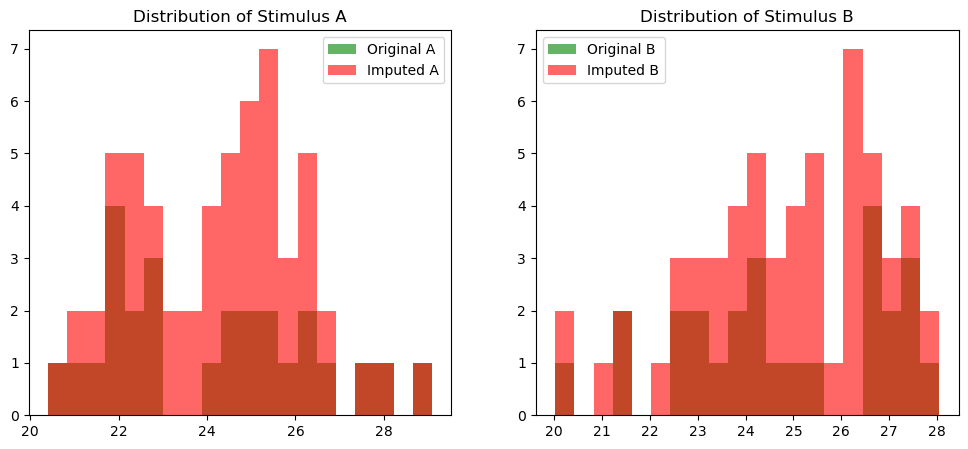

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv
import random

np.random.seed(42)
random.seed(42)  # set seed to ensure results are reproducible(idea 7)

data = pd.read_excel(r"C:\Users\zhang\Desktop\interexp.xlsx")
df = pd.DataFrame(data, columns=["A", "B"])

# Start EM function for missing value imputation (idea 1)
def em_impute(df, max_iter=100, tol=1e-6):
    # Introduce a latent variable for the missing values (idea 3)
    # Using the average of each column to initialize
    df_filled = df.copy()
    for col in df.columns:
        df_filled[col].fillna(df_filled[col].mean(), inplace=True)

    # Iteration to optimize
    prev_likelihood = -np.inf
    for i in range(max_iter):
        # E - step: Assume a bivariate normal distribution(idea 2)
        mu = df_filled.mean().values  # Mean vector for A and B
        sigma = df_filled.cov().values  # Covariance matrix for A and B

        for idx in range(len(df)):
            if df.iloc[idx].isnull().any():  # Check if there are missing values in this row
                obs_idx = ~df.iloc[idx].isnull().values  # True for observed values
                mis_idx = df.iloc[idx].isnull().values  # True for missing values
                
                mu_obs = mu[obs_idx]
                mu_mis = mu[mis_idx]
                
                sigma_obs_obs = sigma[np.ix_(obs_idx, obs_idx)]  # Covariance of observed values
                sigma_obs_mis = sigma[np.ix_(obs_idx, mis_idx)]  # Covariance between observed and missing values
                sigma_mis_mis = sigma[np.ix_(mis_idx, mis_idx)]  # Covariance of missing values

                # Calculate the inverse of the observed covariance matrix
                sigma_inv = inv(sigma_obs_obs)
                
                # Calculate the conditional mean of the missing values given the observed values
                mu_cond = mu_mis + sigma_obs_mis.T @ sigma_inv @ (df_filled.iloc[idx, obs_idx] - mu_obs)
                
                # Impute missing values
                df_filled.iloc[idx, mis_idx] = mu_cond

        # M - step: Update the mean and covariance with the filled data
        mu_new = df_filled.mean().values
        sigma_new = df_filled.cov().values

        # Calculate the likelihood function
        likelihood = np.sum(np.log(multivariate_normal.pdf(df_filled.dropna(), mean=mu_new, cov=sigma_new)))
        
        # Check for convergence using a small tolerance value
        if abs(likelihood - prev_likelihood) < tol:
            print(f"Convergence at {i+1} iterations")
            break
        prev_likelihood = likelihood

    return df_filled

# Using EM algorithm to impute missing values
df_imputed = em_impute(df)

# Compare the distributions of stimulus A and B before and after imputing missing values using visualization techniques (idea 6)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df.dropna()["A"], bins=20, alpha=0.6, label="Original A", color="green")
axes[0].hist(df_imputed["A"], bins=20, alpha=0.6, label="Imputed A", color="red")
axes[0].set_title("Distribution of Stimulus A")
axes[0].legend()

axes[1].hist(df.dropna()["B"], bins=20, alpha=0.6, label="Original B", color="green")
axes[1].hist(df_imputed["B"], bins=20, alpha=0.6, label="Imputed B", color="red")
axes[1].set_title("Distribution of Stimulus B")
axes[1].legend()

plt.show()

# Save the imputed data to a new Excel file for easier review
df_imputed.to_excel("interexp_fill_bivariate.xlsx", index=False)

#the code perfectly accomplish the idea 1 to idea 7,showing the EM algorithm works step by step
